The necessary libraries are imported: `os` for file operations, `cv2` for image processing, `numpy` for numerical operations, `DBSCAN` for clustering, `RANSACRegressor` and `LinearRegression` for robust line fitting, `matplotlib.pyplot` for plotting.

In [165]:
import os
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
import random


In [166]:
image_path = '/content/maxresdefault.jpg'

Check if the file at `image_path` exists. If not, it prints an error message indicating that the image file does not exist, If the file exists, the image is loaded using OpenCV’s `cv2.imread()`. If the image fails to load, an error message is printed then, the loaded image is converted to grayscale using `cv2.cvtColor()`.

In [167]:
if not os.path.exists(image_path):
    print("Image file does not exist at the specified path.")
else:
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load the image. Please check the file.")
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        dges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=200, minLineLength=150, maxLineGap=20)

The Canny edge detection algorithm is applied to the grayscale image using `cv2.Canny()`. This detects edges based on gradients in the image with specified thresholds

In [168]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

Lines are detected in the edge-detected image using the Hough Line Transform with `cv2.HoughLinesP()`. Parameters control the resolution of the accumulator and constraints on line length and gaps.

In [169]:
 def line_intersection(line1, line2):
            x1, y1, x2, y2 = line1[0]
            x3, y3, x4, y4 = line2[0]

            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denom == 0:
                return None

            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

            return [px, py]

A function `line_intersection()` is defined to calculate the intersection point of two lines using their equations. If the lines are parallel (denominator is zero), it returns `None`,For each pair of detected lines, the intersection point is computed using the `line_intersection()` function. Valid intersections (not `None`) are collected into a list.

In [170]:
        intersections = []

        if lines is not None:
            for i in range(len(lines)):
                for j in range(i + 1, len(lines)):
                    pt = line_intersection(lines[i], lines[j])
                    if pt is not None:
                        intersections.append(pt)

        intersections = np.array(intersections)


The list of intersections is filtered to ensure points are within the image dimensions. The filtered points are then converted into a numpy array.

In [171]:
        h, w = image.shape[:2]
        filtered_intersections = [pt for pt in intersections if 0 <= pt[0] <= w and 0 <= pt[1] <= h]
        filtered_intersections = np.array(filtered_intersections)



- If there are filtered intersections, DBSCAN clustering is applied to group the points. The largest cluster is identified, and the vanishing point is calculated as the mean of the points in this cluster.

- If there are enough points in the largest cluster, RANSAC is used to fit a robust line. Inliers (points that fit the line) are identified, and the vanishing point from these inliers is computed. If no inliers are found, the DBSCAN result is used. A combined vanishing point is calculated as the average of the DBSCAN and RANSAC results.

- A figure with two subplots is created. The first subplot displays the image with detected lines overlaid. The second subplot shows the original image with scatter points for filtered intersections and calculated vanishing points (from DBSCAN, RANSAC, and combined). Titles and legends are added, and the plots are displayed.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


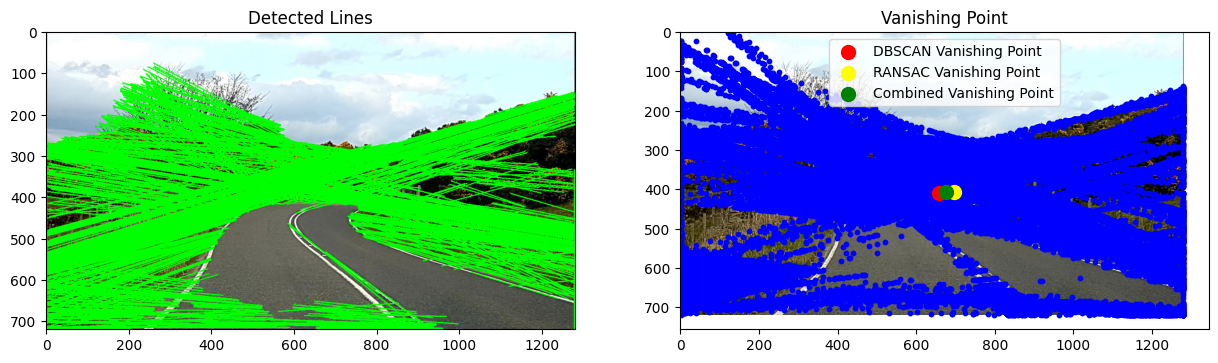

In [172]:
if len(filtered_intersections) > 0:
            dbscan_clustering = DBSCAN(eps=10, min_samples=3).fit(filtered_intersections)
            dbscan_labels = dbscan_clustering.labels_
            dbscan_unique_labels, dbscan_counts = np.unique(dbscan_labels, return_counts=True)
            dbscan_largest_cluster_label = dbscan_unique_labels[np.argmax(dbscan_counts)]
            dbscan_largest_cluster_points = filtered_intersections[dbscan_labels == dbscan_largest_cluster_label]
            vanishing_point_dbscan = np.mean(dbscan_largest_cluster_points, axis=0)

            if len(dbscan_largest_cluster_points) >= 2:
                X = dbscan_largest_cluster_points[:, 0].reshape(-1, 1)
                y = dbscan_largest_cluster_points[:, 1]
                model = LinearRegression()
                ransac_regressor = RANSACRegressor(base_estimator=model, residual_threshold=5, max_trials=2000)
                ransac_regressor.fit(X, y)
                inlier_mask = ransac_regressor.inlier_mask_
                ransac_inliers = dbscan_largest_cluster_points[inlier_mask]
                if len(ransac_inliers) > 0:
                    vanishing_point_ransac = np.mean(ransac_inliers, axis=0)
                else:
                    vanishing_point_ransac = vanishing_point_dbscan
            else:
                vanishing_point_ransac = vanishing_point_dbscan

            combined_vanishing_point = (vanishing_point_dbscan + vanishing_point_ransac) / 2

            plt.figure(figsize=(15, 7))
            image_with_lines = image.copy()
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
            plt.title('Detected Lines')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.scatter(filtered_intersections[:, 0], filtered_intersections[:, 1], color='blue', s=10)
            plt.scatter(vanishing_point_dbscan[0], vanishing_point_dbscan[1], color='red', s=100, label='DBSCAN Vanishing Point')
            plt.scatter(vanishing_point_ransac[0], vanishing_point_ransac[1], color='yellow', s=100, label='RANSAC Vanishing Point')
            plt.scatter(combined_vanishing_point[0], combined_vanishing_point[1], color='green', s=100, label='Combined Vanishing Point')
            plt.title('Vanishing Point')
            plt.legend()
            plt.show()
else:
  print("No intersections found.")

Whole code

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(


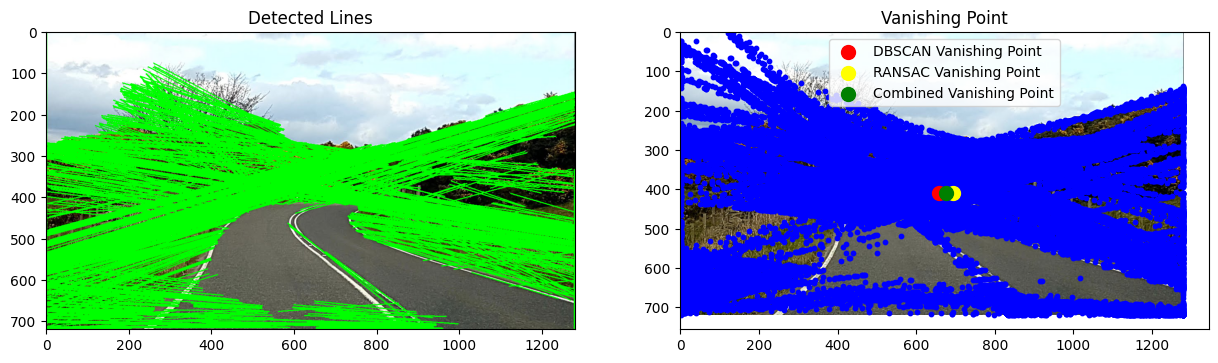

In [173]:
import os
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor
import matplotlib.pyplot as plt
image_path = '/content/maxresdefault.jpg'

if not os.path.exists(image_path):
    print("Image file does not exist at the specified path.")
else:
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load the image. Please check the file.")
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=200, minLineLength=150, maxLineGap=20)

        def line_intersection(line1, line2):
            x1, y1, x2, y2 = line1[0]
            x3, y3, x4, y4 = line2[0]

            denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denom == 0:
                return None

            px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
            py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom

            return [px, py]

        intersections = []

        if lines is not None:
            for i in range(len(lines)):
                for j in range(i + 1, len(lines)):
                    pt = line_intersection(lines[i], lines[j])
                    if pt is not None:
                        intersections.append(pt)

        intersections = np.array(intersections)

        h, w = image.shape[:2]
        filtered_intersections = [pt for pt in intersections if 0 <= pt[0] <= w and 0 <= pt[1] <= h]
        filtered_intersections = np.array(filtered_intersections)

        if len(filtered_intersections) > 0:
            dbscan_clustering = DBSCAN(eps=10, min_samples=3).fit(filtered_intersections)
            dbscan_labels = dbscan_clustering.labels_

            dbscan_unique_labels, dbscan_counts = np.unique(dbscan_labels, return_counts=True)
            dbscan_largest_cluster_label = dbscan_unique_labels[np.argmax(dbscan_counts)]
            dbscan_largest_cluster_points = filtered_intersections[dbscan_labels == dbscan_largest_cluster_label]

            vanishing_point_dbscan = np.mean(dbscan_largest_cluster_points, axis=0)

            if len(dbscan_largest_cluster_points) >= 2:
                X = dbscan_largest_cluster_points[:, 0].reshape(-1, 1)
                y = dbscan_largest_cluster_points[:, 1]

                model = LinearRegression()
                ransac_regressor = RANSACRegressor(base_estimator=model, residual_threshold=5, max_trials=2000)
                ransac_regressor.fit(X, y)

                inlier_mask = ransac_regressor.inlier_mask_
                ransac_inliers = dbscan_largest_cluster_points[inlier_mask]

                if len(ransac_inliers) > 0:
                    vanishing_point_ransac = np.mean(ransac_inliers, axis=0)
                else:
                    vanishing_point_ransac = vanishing_point_dbscan

            else:
                vanishing_point_ransac = vanishing_point_dbscan

            combined_vanishing_point = (vanishing_point_dbscan + vanishing_point_ransac) / 2

            plt.figure(figsize=(15, 7))

            image_with_lines = image.copy()
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
            plt.title('Detected Lines')

            plt.subplot(1, 2, 2)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.scatter(filtered_intersections[:, 0], filtered_intersections[:, 1], color='blue', s=10)
            plt.scatter(vanishing_point_dbscan[0], vanishing_point_dbscan[1], color='red', s=100, label='DBSCAN Vanishing Point')
            plt.scatter(vanishing_point_ransac[0], vanishing_point_ransac[1], color='yellow', s=100, label='RANSAC Vanishing Point')
            plt.scatter(combined_vanishing_point[0], combined_vanishing_point[1], color='green', s=100, label='Combined Vanishing Point')
            plt.title('Vanishing Point')
            plt.legend()

            plt.show()
        else:
            print("No intersections found.")
